### ALS 구현(simple numpy)

#### 데이터 준비 및 함수 선언

In [2]:
from typing import Union, Tuple, List

import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

from IPython.display import Image

import warnings

tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)

In [4]:
base_path = '/opt/ml/input/data/train'
train_df_path = os.path.join(base_path, 'train_ratings.csv')

df = pd.read_csv(train_df_path)
df['viewed'] = np.ones(df.shape[0])

display(df)
print(df.shape)

,user,item,time,viewed
0,11,4643,1230782529,1.0
1,11,170,1230782534,1.0
2,11,531,1230782539,1.0
3,11,616,1230782542,1.0
4,11,2140,1230782563,1.0
...,...,...,...,...
5154466,138493,44022,1260209449,1.0
5154467,138493,4958,1260209482,1.0
5154468,138493,68319,1260209720,1.0
5154469,138493,40819,1260209726,1.0


(5154471, 4)


In [5]:
# MF 모델의 파라미터(p_u, q_i)를 업데이트 하는 ALS 함수
def als(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    K: int,
    regularization: float
) -> None:
    """
    MF 모델의 파라미터를 업데이트하는 ALS

    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. 
               shape: (유저 수, 아이템 수)
    :param K: (int) 잠재 요인 수
    :param regularization: (float) l2 정규화 파라미터
    :return: None
    """
    for user_id, F_user in enumerate(F):
        C_u = np.diag(C[user_id])
        left = np.linalg.inv(np.matmul(np.matmul(Q.T, C_u), Q) + regularization * np.eye(K))
        right = np.matmul(np.matmul(Q.T, C_u), F_user)
        P[user_id] = np.dot(left, right)
        
        
    for item_id, F_item in enumerate(F.T):
        C_i = np.diag(C[:, item_id])
        left = np.linalg.inv(np.matmul(np.matmul(P.T, C_i), P) + regularization * np.eye(K))
        right = np.matmul(np.matmul(P.T, C_i), F_item)
        Q[item_id] = np.dot(left, right)

In [6]:
# ALS의 Loss를 계산하는 함수
def get_ALS_loss(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    regularization: float
) -> float:
    """
    전체 학습 데이터(실제 평가를 내린 데이터)에 대한 ALS의 Loss를 계산합니다.
    
    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. shape: (유저 수, 아이템 수)
    :param regularization: (float) l2 정규화 파라미터
    :return: (float) 전체 학습 데이터에 대한 Loss
    """
    
    user_index, item_index = F.nonzero()
    loss = 0
    for user_id, item_id in zip(user_index, item_index):
        predict_error = pow(F[user_id, item_id] - np.dot(P[user_id].T, Q[item_id]), 2)
        confidence_error = C[user_id, item_id] * predict_error
        loss += confidence_error
    for user_id in range(F.shape[0]):
        regularization_term = regularization * np.sum(np.square(P[user_id]))
        loss += regularization_term
    for item_id in range(F.shape[1]):
        regularization_term = regularization * np.sum(np.square(Q[item_id]))
        loss += regularization_term

    return loss
    

In [7]:
# ALS 기반 MF Train

class MF_ALS(object):
    
    def __init__(self, F, K, C, regularization, epochs, verbose=False):
        self.F = F
        self.num_users, self.num_items = F.shape
        self.K = K
        self.C = C
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose
        
        self.training_process = list()
    
    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        for epoch in range(1, self.epochs + 1):
            als(self.F, self.P, self.Q, self.C, self.K, self.regularization)
            loss = get_ALS_loss(self.F, self.P, self.Q, self.C, self.regularization)
            self.training_process.append((epoch, loss))
            if self.verbose and (epoch % 1 == 0):
                print("epoch: %d, error = %.4f" % (epoch, loss))
        
        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])
    
    def get_predicted_full_matrix(self):
        return np.matmul(self.P, self.Q.T)

In [75]:
user_item_matrix = df.pivot_table('viewed', 'user', 'item').fillna(0)
print(f'유저*아이템 매트릭스 모양 : {user_item_matrix.shape}')
print(f'유저 수 : {df.user.nunique()}')
print(f'아이템 수 : {df.item.nunique()}')

유저*아이템 매트릭스 모양 : (31360, 6807)
유저 수 : 31360
아이템 수 : 6807


In [76]:
user_num = user_item_matrix.shape[0]
movie_num = user_item_matrix.shape[1]
preference_matrix = np.copy(user_item_matrix.iloc[:user_num,:movie_num])
preference_matrix[preference_matrix > 0] = 1

In [77]:
alpha = 40  # confidence lavel, 논문에서 추천
# 신뢰도 행렬
C = 1 + alpha * np.copy(preference_matrix)
# 잠재 요인 수
K = 200  # dimension of latent ventor, 논문에서 추천

# l2 정규화 파라미터
regularization = 40  # r_lambda, 논문에서 추천

# 총 epoch 수
epochs = 5

# 학습 과정의 status print 옵션
verbose = True

#### train

In [55]:
mf_als = MF_ALS(preference_matrix, K, C, regularization, epochs, verbose)
mf_als.train()

epoch: 1, error = 719246.2192
epoch: 2, error = 350743.5330
epoch: 3, error = 329366.8146
epoch: 4, error = 318776.6136
epoch: 5, error = 311959.0940


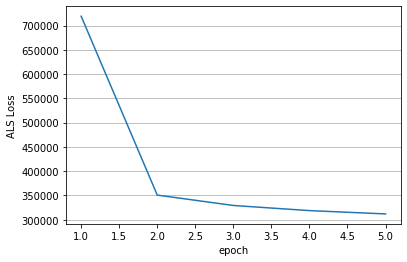

In [56]:
# visualization

train_result_df = mf_als.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.xlabel("epoch")
plt.ylabel("ALS Loss")
plt.grid(axis="y")
plt.show()

In [57]:
predicted_user_item_preference = pd.DataFrame(np.matmul(mf_als.P, mf_als.Q.T), columns=user_item_matrix.iloc[:user_num,:movie_num].columns, index=user_item_matrix.iloc[:user_num,:movie_num].index)

predicted_user_item_preference

item,1,2,3,4,5,6,7,8,9,10,...,1221,1222,1223,1224,1225,1226,1227,1228,1230,1231
user,,,,,,,,,,,,,,,,,,,,,
11,0.999231,0.858009,0.327239,-0.057797,0.222204,-0.057681,-0.000322,0.245145,0.012987,0.464665,...,0.138583,0.164690,0.378898,-0.051878,0.925437,-0.071362,0.022276,-0.320510,0.217362,0.179595
14,0.961965,0.281781,0.356182,0.163524,0.301468,-0.052188,0.936767,0.057581,0.058271,0.091619,...,0.066294,0.059655,0.672980,0.300309,0.371657,0.432520,-0.207787,-0.059603,0.146321,0.137055
18,0.135927,0.064258,0.119261,0.045376,0.114471,0.049428,0.083673,-0.013502,0.064593,-0.004074,...,0.928514,0.112039,0.005685,0.041899,0.233001,0.041085,0.130042,0.068450,0.911653,0.137261
25,0.548203,0.305612,0.260268,0.114874,0.201611,0.249484,-0.035538,0.021790,-0.044467,-0.088769,...,0.616315,0.405703,-0.055503,0.044056,0.282963,0.097333,0.181692,0.297397,0.489798,0.069845
31,0.149422,-0.009976,-0.000778,-0.004366,-0.041533,0.035005,0.018168,-0.002612,-0.014794,0.053165,...,0.064876,0.079172,0.042270,0.026827,0.037688,0.039692,0.019157,-0.026918,-0.029608,0.010358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13770,0.259223,-0.108295,0.218166,0.025773,0.068036,0.008947,0.180141,-0.025732,0.006098,0.095422,...,0.318599,0.321211,0.157394,0.321653,0.951458,0.332543,0.084716,0.090139,0.292230,0.895221
13771,0.262643,0.087388,0.015341,0.040376,-0.004726,0.280219,0.038585,-0.025792,0.030075,0.034744,...,0.576876,0.422394,0.416320,-0.078321,0.176201,-0.125075,0.072508,0.111522,0.288308,-0.030052
13776,0.391392,0.201375,-0.118570,0.010894,0.116101,0.186200,-0.004552,-0.003984,-0.006451,-0.077573,...,0.266458,0.132294,0.002235,0.042875,0.104136,0.033038,0.060924,0.016550,-0.129068,-0.131933


### implicit 라이브러리

#### 데이터 준비

In [ ]:
from typing import Union, Tuple, List

import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

from IPython.display import Image

import warnings

tqdm.pandas()
warnings.filterwarnings("ignore")

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)

In [ ]:
base_path = '/opt/ml/input/data/train'
train_df_path = os.path.join(base_path, 'train_ratings.csv')

df = pd.read_csv(train_df_path)
df['viewed'] = np.ones(df.shape[0])

display(df)
print(df.shape)

,user,item,time,viewed
0,11,4643,1230782529,1.0
1,11,170,1230782534,1.0
2,11,531,1230782539,1.0
3,11,616,1230782542,1.0
4,11,2140,1230782563,1.0
...,...,...,...,...
5154466,138493,44022,1260209449,1.0
5154467,138493,4958,1260209482,1.0
5154468,138493,68319,1260209720,1.0
5154469,138493,40819,1260209726,1.0


(5154471, 4)


In [ ]:
user_item_matrix = df.pivot_table('viewed', 'user', 'item').fillna(0)
print(f'유저*아이템 매트릭스 모양 : {user_item_matrix.shape}')
print(f'유저 수 : {df.user.nunique()}')
print(f'아이템 수 : {df.item.nunique()}')

유저*아이템 매트릭스 모양 : (31360, 6807)
유저 수 : 31360
아이템 수 : 6807


In [ ]:
user_num = user_item_matrix.shape[0]
movie_num = user_item_matrix.shape[1]
preference_matrix = np.copy(user_item_matrix.iloc[:user_num,:movie_num])
preference_matrix[preference_matrix > 0] = 1

### train

In [162]:
import implicit
import scipy

als_model = implicit.als.AlternatingLeastSquares(factors=200, regularization=40, iterations=50)
preference_matrix_csr = scipy.sparse.csr_matrix(preference_matrix)

In [163]:
als_model.fit(preference_matrix_csr)

  0%|          | 0/50 [00:00<?, ?it/s]

In [164]:
als_model_df = pd.DataFrame(np.matmul(als_model.user_factors.to_numpy(), als_model.item_factors.to_numpy().T), columns=user_item_matrix.iloc[:user_num,:movie_num].columns, index=user_item_matrix.iloc[:user_num,:movie_num].index)
als_model_df

item,1,2,3,4,5,6,7,8,9,10,...,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,,,,,,,,,,,,
11,1.023662,0.628551,0.015923,0.001936,0.059498,-0.036197,0.043623,0.019944,0.019956,0.258995,...,-0.001644,-0.004118,-0.000312,-0.002562,-0.000686,-0.000047,-0.002477,0.000497,0.004558,-0.000819
14,0.944270,0.160981,0.067838,0.000267,0.091164,0.017380,0.155208,0.011087,-0.005200,0.055314,...,0.001470,0.002897,-0.000803,0.001809,-0.008073,-0.001762,-0.000144,0.007301,-0.002999,-0.002196
18,0.067344,-0.002495,0.010627,-0.001117,-0.003407,-0.042105,-0.006842,0.000639,0.000771,-0.011873,...,-0.004729,-0.000802,-0.000356,0.000787,-0.003790,-0.002054,-0.001109,-0.002969,-0.002279,-0.002823
25,0.329677,0.178722,0.047135,0.001796,0.010574,0.135763,0.003427,0.001986,0.001045,0.154645,...,0.004600,0.000242,-0.001367,-0.001843,0.005636,0.000196,0.000844,0.000665,0.001243,0.001657
31,0.122684,0.072973,-0.006748,-0.000366,-0.006205,-0.030118,0.007489,0.001737,0.003661,-0.064463,...,0.066500,0.006179,-0.001867,-0.001368,0.078061,-0.001257,-0.003011,0.011384,0.015273,0.015512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,0.367377,0.053495,-0.003675,0.000544,0.006156,0.112752,-0.000395,0.002539,-0.001194,-0.043060,...,0.006049,0.004218,-0.000013,0.001297,0.000474,0.002390,0.002680,0.002914,0.002635,0.000308
138475,0.007562,-0.064902,-0.001539,0.001031,0.004482,0.047509,-0.009321,-0.003757,-0.000005,0.014606,...,-0.002343,-0.005453,0.001000,0.000480,0.004438,-0.004069,0.001453,0.004633,-0.004413,-0.001360
138486,0.916552,0.446643,0.042377,-0.000196,0.016927,0.029431,-0.022285,0.003068,0.007152,0.223235,...,-0.001840,0.002446,0.000185,0.001282,-0.007732,0.002159,0.000963,0.001285,0.000689,0.000086


In [165]:
als_model_df_final = als_model_df - preference_matrix * 1000
als_model_df_final

item,1,2,3,4,5,6,7,8,9,10,...,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,,,,,,,,,,,,
11,-998.976338,0.628551,0.015923,0.001936,0.059498,-0.036197,0.043623,0.019944,0.019956,0.258995,...,-0.001644,-0.004118,-0.000312,-0.002562,-0.000686,-0.000047,-0.002477,0.000497,0.004558,-0.000819
14,-999.055730,0.160981,0.067838,0.000267,0.091164,0.017380,-999.844792,0.011087,-0.005200,0.055314,...,0.001470,0.002897,-0.000803,0.001809,-0.008073,-0.001762,-0.000144,0.007301,-0.002999,-0.002196
18,0.067344,-0.002495,0.010627,-0.001117,-0.003407,-0.042105,-0.006842,0.000639,0.000771,-0.011873,...,-0.004729,-0.000802,-0.000356,0.000787,-0.003790,-0.002054,-0.001109,-0.002969,-0.002279,-0.002823
25,0.329677,0.178722,0.047135,0.001796,0.010574,0.135763,0.003427,0.001986,0.001045,0.154645,...,0.004600,0.000242,-0.001367,-0.001843,0.005636,0.000196,0.000844,0.000665,0.001243,0.001657
31,0.122684,0.072973,-0.006748,-0.000366,-0.006205,-0.030118,0.007489,0.001737,0.003661,-0.064463,...,0.066500,0.006179,-0.001867,-0.001368,-999.921939,-0.001257,-0.003011,0.011384,0.015273,0.015512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138473,-999.632623,0.053495,-0.003675,0.000544,0.006156,0.112752,-0.000395,0.002539,-0.001194,-0.043060,...,0.006049,0.004218,-0.000013,0.001297,0.000474,0.002390,0.002680,0.002914,0.002635,0.000308
138475,0.007562,-0.064902,-0.001539,0.001031,0.004482,0.047509,-0.009321,-0.003757,-0.000005,0.014606,...,-0.002343,-0.005453,0.001000,0.000480,0.004438,-0.004069,0.001453,0.004633,-0.004413,-0.001360
138486,-999.083448,0.446643,0.042377,-0.000196,0.016927,0.029431,-0.022285,0.003068,0.007152,0.223235,...,-0.001840,0.002446,0.000185,0.001282,-0.007732,0.002159,0.000963,0.001285,0.000689,0.000086


In [166]:
result = np.argpartition(als_model_df_final, -10).iloc[:, -10:]
result

item,116823,117176,117533,117881,118696,118700,118900,118997,119141,119145
user,,,,,,,,,,
11,4528,4597,612,1206,1458,2619,3663,2381,1,4790
14,1134,1004,1089,672,482,487,554,561,648,352
18,423,4806,627,4756,1281,2309,179,3057,644,4064
25,1532,146,41,670,580,1016,717,706,360,3567
31,3200,6173,3994,6084,5521,6410,5771,1462,3909,5788
...,...,...,...,...,...,...,...,...,...,...
138473,3654,5762,646,3038,161,5038,3679,77,423,356
138475,632,1685,478,1846,476,472,471,1032,2788,497
138486,1016,4098,2955,668,3989,352,1,3916,237,601


In [167]:
users, items = list(), list()
item_columns = als_model_df_final.columns
for idx in range(result.shape[0]):
    users.extend([result.index[idx]] * 10)
    for i in result.values[idx]:
        items.append(item_columns[i])
        
test_df = pd.DataFrame(zip(users,items), columns=['user','item'])
# test_df.to_csv("/opt/ml/input/code/experiment/als/most_popular_submission.csv", index=False)

In [168]:
#  import pickle

#  with open('implicit_als_model_iter50', 'wb') as f:
#      pickle.dump(als_model, f)